In [1]:
import os 
import re
import torchvision
import numpy as np
import math
import torch
from inv_model import Generator
from tqdm.notebook import tqdm
from torchvision import datasets
import torchvision.transforms as transforms
from utils import *
from skimage.measure import compare_psnr
import matplotlib.pyplot as plt
import yaml
import warnings
warnings.filterwarnings("ignore")

## Optimization Code

In [2]:
def loss_geocross(latent):
        if latent.size() == (1, 512):
            return 0
        else:
            num_latents  = latent.size()[1]
            X = latent.view(-1, 1, num_latents, 512)
            Y = latent.view(-1, num_latents, 1, 512)
            A = ((X - Y).pow(2).sum(-1) + 1e-9).sqrt()
            B = ((X + Y).pow(2).sum(-1) + 1e-9).sqrt()
            D = 2 * torch.atan2(A, B)
            D = ((D.pow(2) * 512).mean((1, 2)) / 8.).mean()
            return D

class MappingProxy(torch.nn.Module):
    def __init__(self,gaussian_ft):
        super(MappingProxy,self).__init__()
        self.mean = gaussian_ft["mean"]
        self.std = gaussian_ft["std"]
        self.lrelu = torch.nn.LeakyReLU(0.2)
    def forward(self,x):
        x = self.lrelu(self.std * x + self.mean)
        return x

class SphericalOptimizer():
    def __init__(self, params):
        self.params = params
        with torch.no_grad():
            self.radii = {param: (param.pow(2).sum(tuple(range(2,param.ndim)), keepdim=True)+1e-9).sqrt() for param in params}
    @torch.no_grad()
    def step(self, closure=None):
        for param in self.params:
            param.data.div_((param.pow(2).sum(tuple(range(2,param.ndim)), keepdim=True)+1e-9).sqrt())
            param.mul_(self.radii[param])



class LatentOptimizer(torch.nn.Module):
    def __init__(self,configs,perc_m):
        super().__init__()
        self.configs = configs
        self.perc_m=perc_m

        device = self.configs['device']
        gen = torch.nn.DataParallel(Generator(256, 512, 8),device_ids=[0])
        gen.load_state_dict(torch.load(self.configs['ckpt'])["g_ema"], strict=True)
        gen.eval()
        
        self.gen = gen.module.to(device)
        self.gen.start_layer = 0
        self.gen.end_layer = self.configs['end_layer']
        if self.configs['inv_method']=='rtil':
            self.mpl = MappingProxy(torch.load('./pretrained/gauss_rtil.pt',map_location=device))
        else:
            self.mpl = MappingProxy(torch.load('./pretrained/gauss_van.pt',map_location=device))
        self.init_state()

    def init_state(self):
        device = self.configs['device']
        self.project = self.configs['project']
        self.steps = self.configs['steps']

        self.layer_in = None
        self.best = None
        self.current_step = 0

    
        # save filters
        perc = self.perc_m / 100
        m = int(perc * (3 * self.configs['image_size'] ** 2))

        self.indices = torch.tensor(np.random.choice(np.arange(256 * 256 * 3), m, replace=False))
        self.filters = torch.ones((256 *  256 * 3), device=device).normal_().unsqueeze(0).to(device)
        self.sign_pattern = (torch.rand(256 * 256 * 3) >
                            0.5).type(torch.int32).to(device)
        self.sign_pattern = 2 * self.sign_pattern - 1
        bs = self.configs['batch_size']
        # initialization
        noises_single = self.gen.make_noise(bs)
        self.noises = []
        for noise in noises_single:
            self.noises.append(noise.normal_())
            self.latent_z = torch.randn(
                        (bs, 14, 512),
                        dtype=torch.float,
                        requires_grad=True, device=device)
            self.gen_outs = [None]
 


    def get_lr(self, t, initial_lr, rampdown=0.75, rampup=0.05):
        lr_ramp = min(1, (1 - t) / rampdown)
        lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
        lr_ramp = lr_ramp * min(1, t / rampup)
        return initial_lr * lr_ramp


    def invert_(self,img, start_layer, noise_list, steps, index, reference_vector=None):
        learning_rate = self.configs['lr'] [index]
        print(f"Running round {index + 1} / {len(self.configs['steps'])} of ILO.")
        # noise_list containts the indices of nodes that we will be optimizing over
        for i in range(len(self.noises)):
            if i in noise_list:
                self.noises[i].requires_grad = True
            else:
                self.noises[i].requires_grad = False
        with torch.no_grad():
            if start_layer == 0:
                var_list = [self.latent_z] + self.noises
            else:
                self.gen_outs[-1].requires_grad = True
                var_list = [self.latent_z] + self.noises + [self.gen_outs[-1]]
                prev_gen_out = torch.ones(self.gen_outs[-1].shape, device=self.gen_outs[-1].device) * self.gen_outs[-1]
            prev_latent = torch.ones(self.latent_z.shape, device=self.latent_z.device) * self.latent_z
            prev_noises = [torch.ones(noise.shape, device=noise.device) * noise for noise in
                           self.noises]

            # set network that we will be optimizing over
            self.gen.start_layer = start_layer
            self.gen.end_layer = self.configs['end_layer']

        optimizer = torch.optim.Adam(var_list, lr=learning_rate)
        ps = SphericalOptimizer([self.latent_z] + self.noises)
        pbar = tqdm(range(steps))
        self.current_step += steps

        mse_min = np.inf

        mse_loss = 0
        reference_loss = 0
        for i in pbar:
            if self.configs['lr_same_pace']:
                total_steps = sum(self.configs['steps'])
                t = i / total_steps
            else:
                t = i / steps
            lr = self.get_lr(t, learning_rate)
            optimizer.param_groups[0]["lr"] = lr
            latent_w = self.mpl(self.latent_z)
            img_gen, _ = self.gen([latent_w],
                                  input_is_latent=True,
                                  noise=self.noises,
                                  layer_in=self.gen_outs[-1],)
  
            
            


            #- Calculate loss                           -#
            loss = 0
            real_obsv = partial_circulant_torch(img, self.filters, self.indices,
                                                   self.sign_pattern)
            gen_obsv = partial_circulant_torch(img_gen, self.filters, self.indices,
                                                   self.sign_pattern)
            mse_loss = F.mse_loss(real_obsv, gen_obsv).mean()
            reference_vector =img
            loss += mse_loss
            loss += self.configs['geocross']* loss_geocross(self.latent_z[2 * start_layer:])
            if reference_vector is not None:
                reference_loss = F.mse_loss(img_gen, reference_vector)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if self.project:
                ps.step()

            if (reference_vector is not None) and self.configs['save_on_ref'] and reference_loss < mse_min:
                mse_min = reference_loss
                self.best = img_gen.detach().cpu().numpy().transpose(0,2,3,1)
            elif mse_loss < mse_min:
                mse_min = mse_loss
                self.best = img_gen.detach().cpu().numpy().transpose(0,2,3,1)

            pbar.set_description(
                (
                    f" mse: {mse_loss:.4f};"
                    f" img_mse: {reference_loss:.4f};"
                )
            )
        
        with torch.no_grad():
            latent_w = self.mpl(self.latent_z)
            self.gen.end_layer = self.gen.start_layer
            intermediate_out, _  = self.gen([latent_w],
                                             input_is_latent=True,
                                             noise=self.noises,
                                             layer_in=self.gen_outs[-1],
                                             skip=None)
            self.gen_outs.append(intermediate_out)
            self.gen.end_layer = self.configs['end_layer']

    def invert(self,img,reference_vector=None):
        for i, steps in enumerate(self.configs['steps']):
            begin_from = i 
            if begin_from > self.configs['end_layer']:
                raise Exception('Attempting to go after end layer...')
            self.invert_(img,begin_from, range(5 + 2 * begin_from), int(steps), i, reference_vector)
        return img.cpu().numpy().transpose(0,2,3,1), (self.latent_z, self.noises, self.gen_outs), self.best



## ILO-RTIL

In [3]:
with open('config.yaml') as f:
    configs = yaml.safe_load(f)
Rtil_configs=configs.get('Rtil')
trans = transforms.Compose([transforms.Resize((Rtil_configs['image_size'])),transforms.ToTensor()])
test_dataset    = datasets.ImageFolder(Rtil_configs['test_set'], transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=Rtil_configs['batch_size'],drop_last=False,shuffle=False)
for measurements in Rtil_configs['perc_m']:
    original=[]
    recovered=[]
    print('*'*10,'Percentage of Measurements',measurements,'*'*10)
    for i, data in enumerate(test_dataloader):
        latent_opt=LatentOptimizer(Rtil_configs,measurements)
        img=data[0].to(Rtil_configs['device'])
        org_img,latent,img_gen=latent_opt.invert(img)
        original.append(org_img)
        recovered.append(np.clip(img_gen,0,1))
        psnr_img=compare_psnr(original[i], recovered[i])
        print('*'*10,'PSNR Per image',psnr_img,'*'*10)
        print('Number of images recovered',i+1, 'Out of',len(test_dataloader))
        torch.cuda.empty_cache()
    Original  = np.vstack(original)
    Recovered = np.vstack(recovered)
    print('*'*10,'Percentage of Measurements End of Experiment',measurements,'*'*10)
    psnr      = [compare_psnr(x, y) for x,y in zip(Original, Recovered)]
    print('*'*10,'Percentage of Measurements',measurements,'*'*10)
    print('*'*10,'PSNR',np.mean(psnr),'*'*10)
    original.clear()
    recovered.clear()
    path=Rtil_configs['save_folder']
    if not os.path.exists(path):
        os.makedirs(path)
             
    np.save(path+"/original.npy", Original)
    np.save(path+"/recovered_"+ str(measurements)+ "%" + ".npy", Recovered)
    np.save(path+"/psnr_" + str(measurements)+ "%" + ".npy",np.mean(psnr))



********** Percentage of Measurements 10 **********
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 35.03872687284109 **********
Number of images recovered 1 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 33.06008980553859 **********
Number of images recovered 2 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 33.82921391656644 **********
Number of images recovered 3 Out of 3
********** Percentage of Measurements End of Experiment 10 **********
********** Percentage of Measurements 10 **********
********** PSNR 33.97601019831537 **********
********** Percentage of Measurements 5 **********
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 31.328505972647008 **********
Number of images recovered 1 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 30.737242162190242 **********
Number of images recovered 2 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 29.461988011904886 **********
Number of images recovered 3 Out of 3
********** Percentage of Measurements End of Experiment 5 **********
********** Percentage of Measurements 5 **********
********** PSNR 30.509245382247382 **********
********** Percentage of Measurements 1 **********
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 24.950905907839566 **********
Number of images recovered 1 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 24.481149185726725 **********
Number of images recovered 2 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 23.73104259803259 **********
Number of images recovered 3 Out of 3
********** Percentage of Measurements End of Experiment 1 **********
********** Percentage of Measurements 1 **********
********** PSNR 24.38769923053296 **********


## ILO

In [4]:
with open('config.yaml') as f:
    configs = yaml.safe_load(f)
van_configs=configs.get('Vanilla')
trans = transforms.Compose([transforms.Resize((van_configs['image_size'])),transforms.ToTensor()])
test_dataset    = datasets.ImageFolder(van_configs['test_set'], transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=van_configs['batch_size'],drop_last=False,shuffle=False)
for measurements in van_configs['perc_m']:
    original=[]
    recovered=[]
    print('*'*10,'Percentage of Measurements',measurements,'*'*10)
    for i, data in enumerate(test_dataloader):
        latent_opt=LatentOptimizer(van_configs,measurements)
        img=data[0].to(van_configs['device'])
        org_img,latent,img_gen=latent_opt.invert(img)
        original.append(org_img)
        recovered.append(np.clip(img_gen,0,1))
        psnr_img=compare_psnr(original[i], recovered[i])
        print('*'*10,'PSNR Per image',psnr_img,'*'*10)
        print('Number of images recovered',i+1, 'Out of',len(test_dataloader))
        torch.cuda.empty_cache()
    Original  = np.vstack(original)
    Recovered = np.vstack(recovered)
    print('*'*10,'Percentage of Measurements End of Experiment',measurements,'*'*10)
    psnr      = [compare_psnr(x, y) for x,y in zip(Original, Recovered)]
    print('*'*10,'Percentage of Measurements',measurements,'*'*10)
    print('*'*10,'PSNR',np.mean(psnr),'*'*10)
    original.clear()
    recovered.clear()
    path=van_configs['save_folder']
    if not os.path.exists(path):
        os.makedirs(path)
             
    np.save(path+"/original.npy", Original)
    np.save(path+"/recovered_"+ str(measurements)+ "%" + ".npy", Recovered)
    np.save(path+"/psnr_" + str(measurements)+ "%" + ".npy",np.mean(psnr))



********** Percentage of Measurements 10 **********
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 32.34312424939739 **********
Number of images recovered 1 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 31.17650842820303 **********
Number of images recovered 2 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 31.629365460894306 **********
Number of images recovered 3 Out of 3
********** Percentage of Measurements End of Experiment 10 **********
********** Percentage of Measurements 10 **********
********** PSNR 31.716332712831576 **********
********** Percentage of Measurements 5 **********
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 29.8788813226154 **********
Number of images recovered 1 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 27.573551514429695 **********
Number of images recovered 2 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 29.01827065630753 **********
Number of images recovered 3 Out of 3
********** Percentage of Measurements End of Experiment 5 **********
********** Percentage of Measurements 5 **********
********** PSNR 28.823567831117543 **********
********** Percentage of Measurements 1 **********
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 23.520853603353487 **********
Number of images recovered 1 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 20.49617974214896 **********
Number of images recovered 2 Out of 3
Running round 1 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

Running round 2 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 3 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 4 / 5 of ILO.


  0%|          | 0/1000 [00:00<?, ?it/s]

Running round 5 / 5 of ILO.


  0%|          | 0/2000 [00:00<?, ?it/s]

********** PSNR Per image 22.31829300290245 **********
Number of images recovered 3 Out of 3
********** Percentage of Measurements End of Experiment 1 **********
********** Percentage of Measurements 1 **********
********** PSNR 22.111775449468297 **********


## Make Results

In [5]:

def get_psnr_results(direct):
    results={}
    myfiles = [myfile for myfile in os.listdir(direct) if myfile.startswith("psnr")]
    for files in myfiles:
        psnr=np.load(direct + files)
        no_meas=int(re.search(r'\d+', files)[0])
        results[no_meas]=psnr
    return results 

    

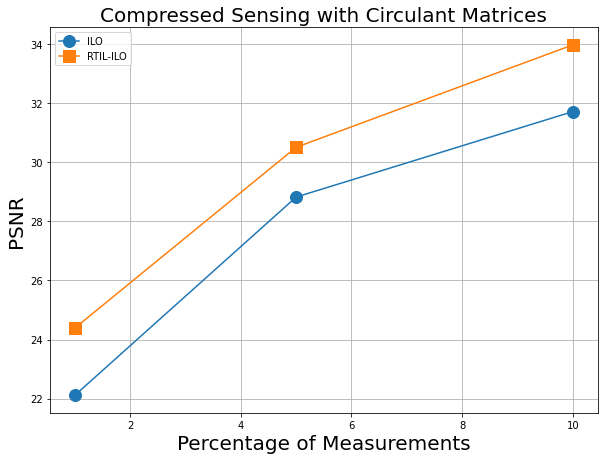

In [6]:
fig = plt.gcf()
fig.set_size_inches(8.5, 6.5)
van_results=get_psnr_results('./results/van/')
rtil_results=get_psnr_results('./results/rtil/')
ilo = sorted(van_results.items(),reverse=True) 
rtil= sorted(rtil_results.items(),reverse=True) 
m, psnr_ilo = zip(*ilo) 
m, psnr_rtil = zip(*rtil) 
plt.plot(m, psnr_ilo,marker='o',markersize=12,label='ILO')
plt.plot(m, psnr_rtil,marker='s',markersize=12,label='RTIL-ILO')
plt.xlabel('Percentage of Measurements',fontsize=20)
plt.ylabel('PSNR',fontsize=20)
plt.legend()
plt.grid()
plt.title('Compressed Sensing with Circulant Matrices',fontsize=20)
plt.tight_layout()
plt.show()
